# Heart Disease Classification

## Imports

In [226]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, log_loss, average_precision_score, roc_curve, roc_auc_score, auc
from pyarrow import feather
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
os.chdir("/home/darkstar/Documents/pg-dbda/module7_statistics/Daywise Study Material/datasets/heart_disease")


In [3]:
import matplotlib.style as style
import seaborn as sns
style.available
style.use('classic')
#style.available

In [4]:
%%time
heart = pd.read_csv("processed.cleveland.data", header=None)
heart.columns = [ 'age', 'sex', 'cp', 'restbp',
                 'chol', 'fbs', 'restecg', 'thalach',
                 'exang', 'oldpeak', 'slope', 'ca',
                 'thal', 'hd']
heart = heart.to_feather("processed_cleveland.feather")
heart = feather.read_feather('processed_cleveland.feather')
heart

CPU times: user 20.2 ms, sys: 14 ms, total: 34.2 ms
Wall time: 48.9 ms


age  sex   cp  restbp   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0   145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0   160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0   120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0   130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0   130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...     ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0   110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0   144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0   130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0   130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0   138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca thal  hd  
0      3.0  0.0  6.0   0  
1      2.0  3.0  3.0   2  
2      2.0  2.0  7.0   1  
3      3.0  0.0  3.0   0  
4      1.0  0.0  3.0   0  
..     ...  ...  ...  ..  
298    2.0  0.0  7.0   1  
299    2.0  2.0  7.0   2  
300    2.0  1.0  7.0   3  
301    2.0  1.0  3.0   1  
302    1.0    ?  3.0   0  

[303 rows x 14 columns]

## Feature Documentation

## One Hot Encoding

- **age**: *float*
- **sex**:
    - Category
    - 0: Female
    - 1: Male
- **cp (chest pain)**:
    - Category
    - 1: Typical Angina
    - 2: Atypical Angina
    - 3: Non-Anginal Pain
    - 4: Asymptomatic
- **restbp (resting blood pressure)**: *float*
- **chol (serum cholesterol)**: *float*
- **fbs (fasting blood sugar)**:
    - Category
    - 0: >= 120 mg/dl
    - 1: <= 120 mg/dl
- **restecg (resting electrocardiographic results)**:
    - Category
    - 1: Normal
    - 2: ST-T Wave Abnormality
    - 3: Probable or Definite Left Ventricular Hypertrophy
- **thalach (maximum heart rate)**: *float*
- **exang (exercise induced angina)**:
    - Category
    - 0: No
    - 1: Yes
- **oldpeak (ST depression induced by exercise)**: *float*
- **slope (slope of peak exercise ST segment)**:
    - Category
    - 1: Upsloping
    - 2: Flat
    - 3: Downsloping
- **ca (number of major vessels colored by fluoroscopy)**: *float*
- **thal (thalium heart scan)**:
    - Category
    - 3: Normal
    - 6: Fixed Defect
    - 7: Reversible Defect

In [5]:
heart.columns

Index(['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'],
      dtype='object')

In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      303 non-null    float64
 1   sex      303 non-null    float64
 2   cp       303 non-null    float64
 3   restbp   303 non-null    float64
 4   chol     303 non-null    float64
 5   fbs      303 non-null    float64
 6   restecg  303 non-null    float64
 7   thalach  303 non-null    float64
 8   exang    303 non-null    float64
 9   oldpeak  303 non-null    float64
 10  slope    303 non-null    float64
 11  ca       303 non-null    object 
 12  thal     303 non-null    object 
 13  hd       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [282]:
heart.describe()

age         sex          cp      restbp        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          hd  
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000  
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.937294  
std      0.994971   22.875003    0.469794    1.161075    0.616226    1.228536  
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000  
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000  
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000  
75%      2.000000  166.000000    1.000000    1.600000    2.000000    2.000000  
max      2.000000  202.000000    1.000000    6.200000    3.000000    4.000000

In [8]:
heart.apply(np.unique)

age        [29.0, 34.0, 35.0, 37.0, 38.0, 39.0, 40.0, 41....
sex                                               [0.0, 1.0]
cp                                      [1.0, 2.0, 3.0, 4.0]
restbp     [94.0, 100.0, 101.0, 102.0, 104.0, 105.0, 106....
chol       [126.0, 131.0, 141.0, 149.0, 157.0, 160.0, 164...
fbs                                               [0.0, 1.0]
restecg                                      [0.0, 1.0, 2.0]
thalach    [71.0, 88.0, 90.0, 95.0, 96.0, 97.0, 99.0, 103...
exang                                             [0.0, 1.0]
oldpeak    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...
slope                                        [1.0, 2.0, 3.0]
ca                                   [0.0, 1.0, 2.0, 3.0, ?]
thal                                      [3.0, 6.0, 7.0, ?]
hd                                           [0, 1, 2, 3, 4]
dtype: object

In [9]:
heart[(heart.ca == "?") | (heart.thal == "?")]

age  sex   cp  restbp   chol  fbs  restecg  thalach  exang  oldpeak  \
87   53.0  0.0  3.0   128.0  216.0  0.0      2.0    115.0    0.0      0.0   
166  52.0  1.0  3.0   138.0  223.0  0.0      0.0    169.0    0.0      0.0   
192  43.0  1.0  4.0   132.0  247.0  1.0      2.0    143.0    1.0      0.1   
266  52.0  1.0  4.0   128.0  204.0  1.0      0.0    156.0    1.0      1.0   
287  58.0  1.0  2.0   125.0  220.0  0.0      0.0    144.0    0.0      0.4   
302  38.0  1.0  3.0   138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca thal  hd  
87     1.0  0.0    ?   0  
166    1.0    ?  3.0   0  
192    2.0    ?  7.0   1  
266    2.0  0.0    ?   2  
287    2.0    ?  7.0   0  
302    1.0    ?  3.0   0

In [10]:
df = heart[(heart.ca != "?") & (heart.thal != "?")]
df

age  sex   cp  restbp   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0   145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0   160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0   120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0   130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0   130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...     ...    ...  ...      ...      ...    ...      ...   
297  57.0  0.0  4.0   140.0  241.0  0.0      0.0    123.0    1.0      0.2   
298  45.0  1.0  1.0   110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0   144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0   130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0   130.0  236.0  0.0      2.0    174.0    0.0      0.0   

     slope   ca thal  hd  
0      3.0  0.0  6.0   0  
1      2.0  3.0  3.0   2  
2      2.0  2.0  7.0   1  
3      3.0  0.0  3.0   0  
4      1.0  0.0  3.0   0  
..     ...  ...  ...  ..  
297    2.0  0.0  7.0   1  
298    2.0  0.0  7.0   1  
299    2.0  2.0  7.0   2  
300    2.0  1.0  7.0   3  
301    2.0  1.0  3.0   1  

[297 rows x 14 columns]

## Eploratory Data Analysis

### Countplot

In [11]:
df_count = df.copy()
hd_mapping = {
    0: "No Disease",
    1: "Typical Angina",
    2: "Atypical Angina",
    3: "Non-Anginal Pain",
    4: "Asymptomatic"
}

sex_mapping = {
    0: "Female",
    1: "Male"
}

# Replace numeric codes with text labels in the DataFrame
df_count['hd'] = df_count['hd'].map(hd_mapping)
df_count['sex'] = df_count['sex'].map(sex_mapping)

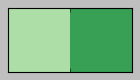

In [12]:
sequential_colors = sns.color_palette("Greens", 2)
sns.palplot(sequential_colors)

Text(0, 0.5, 'heart disease type')

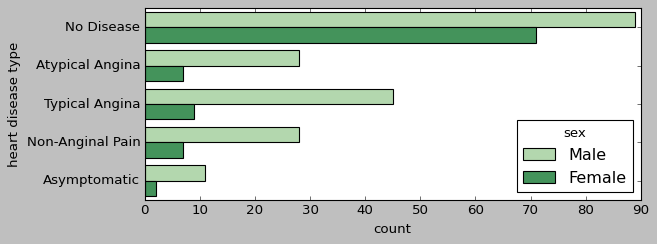

In [13]:
plt.figure(figsize=(8,3))
sns.countplot(data=df_count, y=df_count['hd'], hue='sex', palette=sequential_colors)
plt.ylabel("heart disease type")

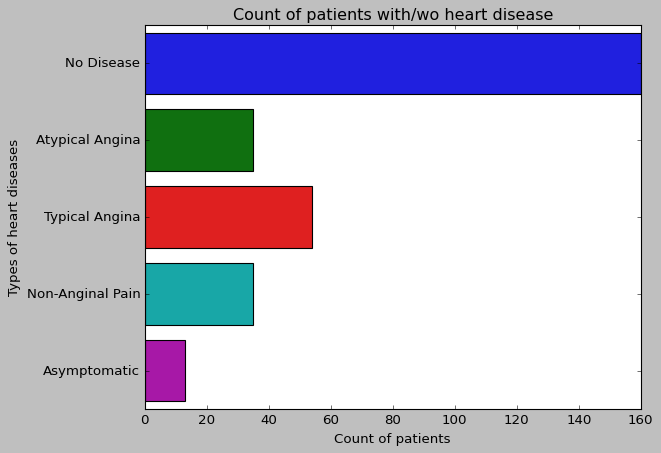

In [14]:
sns.countplot(data=df_count, y='hd')
plt.title("Count of patients with/wo heart disease")
plt.xlabel("Count of patients")
plt.ylabel("Types of heart diseases")
plt.show()

### Distribution of target variable

Text(0.5, 1.0, 'Distribution of heart attacks')

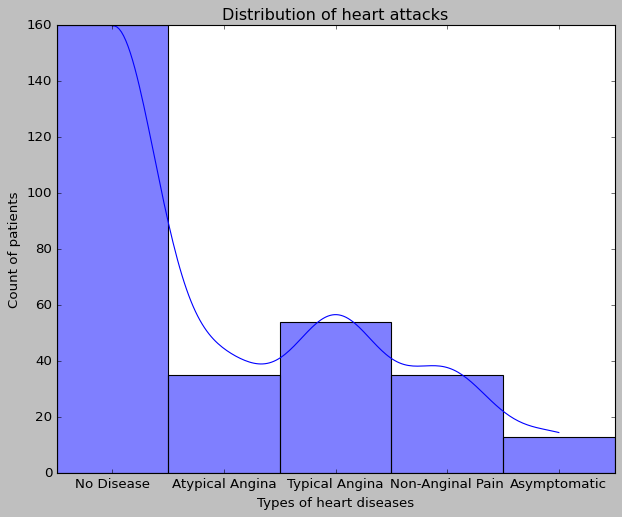

In [21]:
plt.figure(figsize=(9,7))
sns.histplot(df_count['hd'], kde=True)
plt.xlabel("Types of heart diseases")
plt.ylabel('Count of patients')
plt.title('Distribution of heart attacks')

### Correlation Matrix

<Axes: >

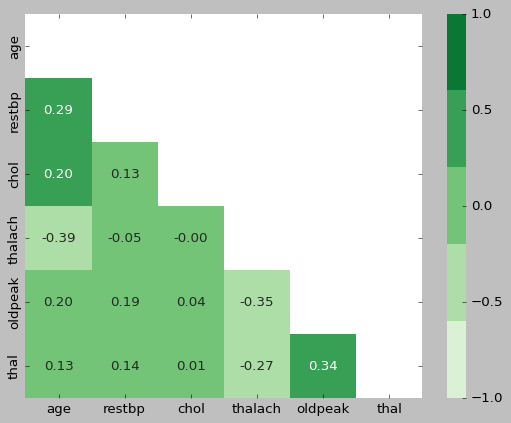

In [103]:
corr_df = df[['age', 'restbp', 'chol', 'thalach', 'oldpeak', 'thal']]
corr_mat = corr_df.corr()
mask = np.triu(np.ones_like(corr_mat))
sequential_colors = sns.color_palette("Greens", 5)
sns.heatmap(data=corr_mat, annot=True, mask = mask, vmin=-1, vmax=1, cmap=sequential_colors, fmt='0.2f')

### correlation matrix with clustering using dendograms

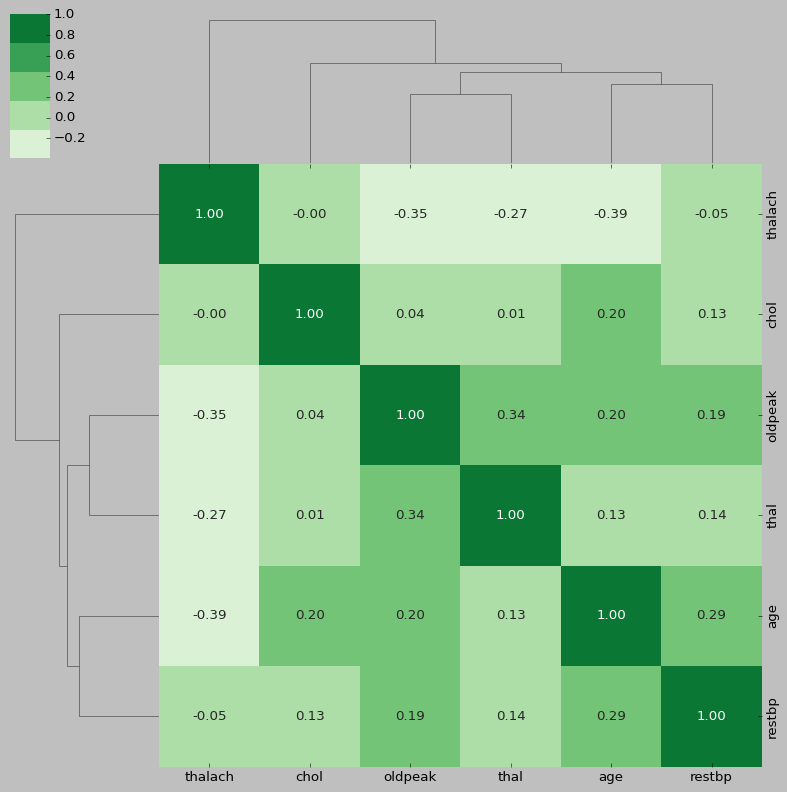

In [181]:
corr_df = df[['age', 'restbp', 'chol', 'thalach', 'oldpeak', 'thal']]
corr_mat = corr_df.corr()
mask = np.triu(np.ones_like(corr_mat))
sequential_colors = sns.color_palette("Greens", 5)
sns.clustermap(data=corr_mat, annot=True, cmap=sequential_colors, fmt='0.2f')

### PairPlot for checking the relationships between independent variables using scatterplot

<Figure size 400x400 with 0 Axes>

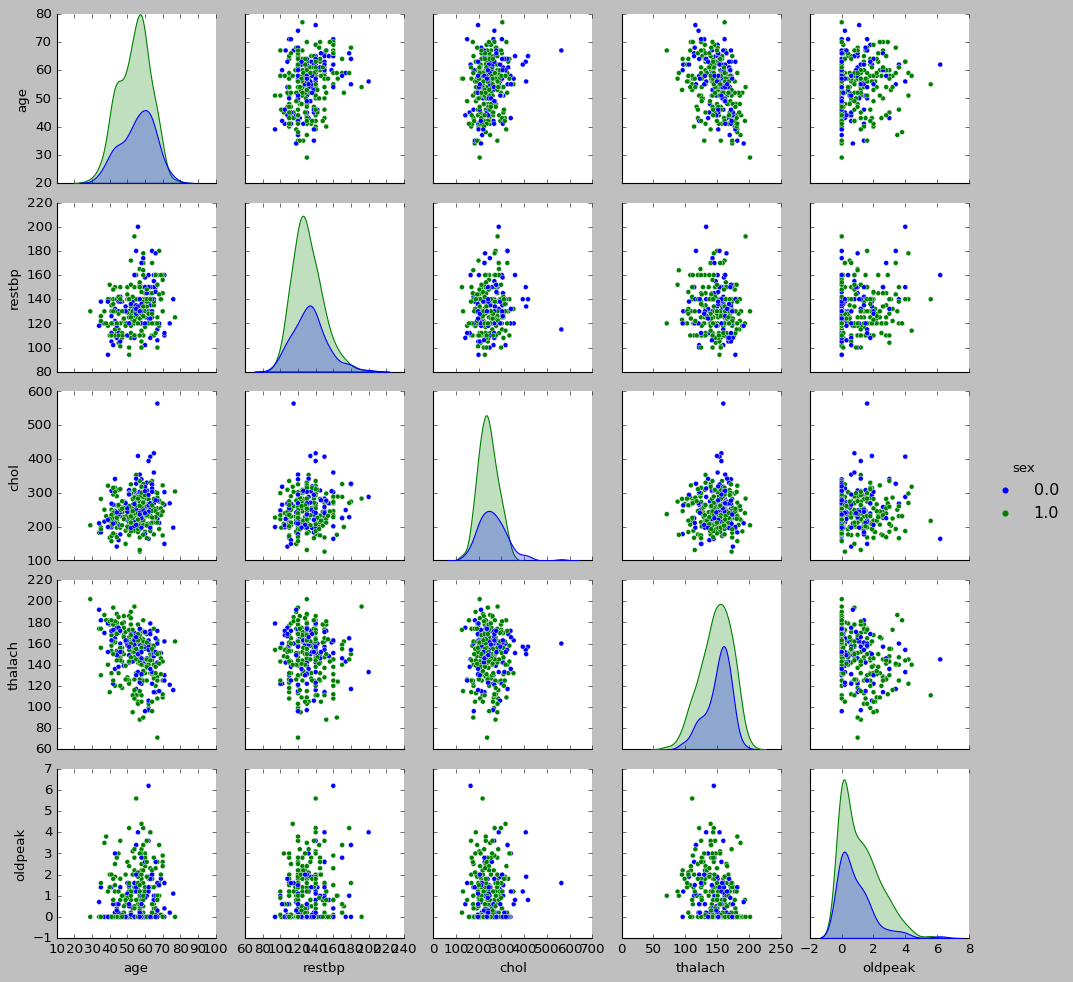

In [23]:
plt.figure(figsize=(5,5))
pair_df = df[['sex','age', 'restbp', 'chol', 'thalach', 'oldpeak', 'thal']]
sns.pairplot(pair_df, hue='sex')

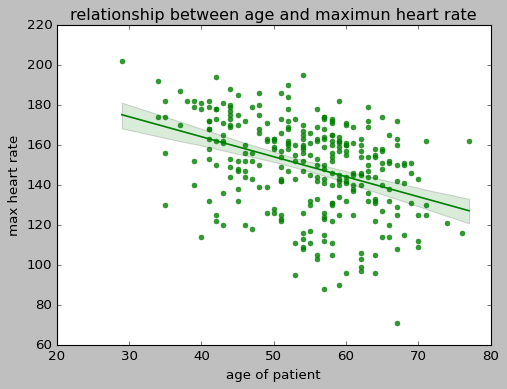

In [285]:
plt.figure(figsize=(7,5))
sns.regplot(data=pair_df, x='age', y='thalach',color='g')
plt.xlabel('age of patient')
plt.ylabel('max heart rate')
plt.title('relationship between age and maximun heart rate')
plt.show()

**Regplot conclusion:** 
age and max heart rate `thalach` has negative correaltion meaning as they age increaseing there is drop in max heart rate.

## splitting the data into training and testing

In [30]:
X = df.drop(['hd'], axis = 1).copy()
y = df['hd'].copy()
df['hd'].unique()

'''we are only interested if someone has heart disease or not which is 0 or 1. 
   so we convert the types of all heart diesease to 1 '''

y_index = y > 0
y[y_index] = 1


In [81]:
# Encoding categorical data
X_encoded = pd.get_dummies(X, columns=['cp','restecg','slope','thal'], dtype=int)
X_encoded['ca'] = X_encoded['ca'].astype('float')
X_encoded

age  sex  restbp   chol  fbs  thalach  exang  oldpeak   ca  cp_1.0  ...  \
0    63.0  1.0   145.0  233.0  1.0    150.0    0.0      2.3  0.0       1  ...   
1    67.0  1.0   160.0  286.0  0.0    108.0    1.0      1.5  3.0       0  ...   
2    67.0  1.0   120.0  229.0  0.0    129.0    1.0      2.6  2.0       0  ...   
3    37.0  1.0   130.0  250.0  0.0    187.0    0.0      3.5  0.0       0  ...   
4    41.0  0.0   130.0  204.0  0.0    172.0    0.0      1.4  0.0       0  ...   
..    ...  ...     ...    ...  ...      ...    ...      ...  ...     ...  ...   
297  57.0  0.0   140.0  241.0  0.0    123.0    1.0      0.2  0.0       0  ...   
298  45.0  1.0   110.0  264.0  0.0    132.0    0.0      1.2  0.0       1  ...   
299  68.0  1.0   144.0  193.0  1.0    141.0    0.0      3.4  2.0       0  ...   
300  57.0  1.0   130.0  131.0  0.0    115.0    1.0      1.2  1.0       0  ...   
301  57.0  0.0   130.0  236.0  0.0    174.0    0.0      0.0  1.0       0  ...   

     cp_4.0  restecg_0.0  restecg_1.0  restecg_2.0  slope_1.0  slope_2.0  \
0         0            0            0            1          0          0   
1         1            0            0            1          0          1   
2         1            0            0            1          0          1   
3         0            1            0            0          0          0   
4         0            0            0            1          1          0   
..      ...          ...          ...          ...        ...        ...   
297       1            1            0            0          0          1   
298       0            1            0            0          0          1   
299       1            1            0            0          0          1   
300       1            1            0            0          0          1   
301       0            0            0            1          0          1   

     slope_3.0  thal_3.0  thal_6.0  thal_7.0  
0            1         0         1         0  
1            0         1         0         0  
2            0         0         0         1  
3            1         1         0         0  
4            0         1         0         0  
..         ...       ...       ...       ...  
297          0         0         0         1  
298          0         0         0         1  
299          0         0         0         1  
300          0         0         0         1  
301          0         1         0         0  

[297 rows x 22 columns]

## Base Decision Tree Model

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [33]:
plt.figure(figsize=(200,100))
plot_tree(dtc.fit(X_train, y_train),
         filled=True,
         rounded=True,
         class_names=["No heart disease", 'yes heart disease'],
         feature_names=X_encoded.columns)
plt.show()


Accuracy for Preliminary Decision Tree : 76.0 % 


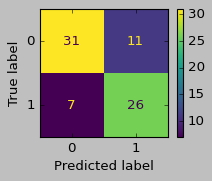

In [278]:
y_pred = dtc.predict(X_test)
print(f"Accuracy for Preliminary Decision Tree : {accuracy_score(y_test, y_pred)*100} % ")
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(3,2))
cmp.plot(ax = ax)
plt.show()


In the confusion matrix, we see that of the $31+11 = 42$ people that does not have **Heart Disease** 31(74%) were correctly classified. And of the $7+26 = 33$ people that have **Heart Disease**, 26(79%) were correctly classified.

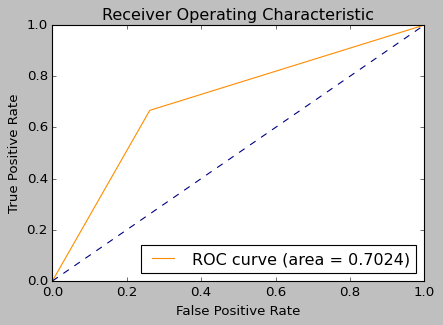

In [310]:
y_scores = dtc.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
            
# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % np.mean(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Cost Complexity Pruning - Visualize Alpha
Decision Tress are notorious for being overfit to the Training Dataset and there are a lot of parameters like max_depth, min_samples that are designed to reduce overfitting, however, pruning a tree with **cost complexity pruning** can simplify the whole process of finding a small tree that improves the accuracy with the testing dataset.

pruning a decision tree is all about finding the right value for the pruning parameter, **alpha** which controls how little or how much pruning happends.

**NOTE:** we omit the max value for aplha wth ccp_aplhas = `ccp_aplhas[:-1]` because it would prune all leaves, leaving us with only a root instead of a tree.

In [279]:
path = dtc.cost_complexity_pruning_path(X_train, y_train) # determines the values for alpha
ccp_alphas = path.ccp_alphas # extract diff values of alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []
for i in ccp_alphas:
    dtc = DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    dtc.fit(X_train, y_train)
    clf_dts.append(dtc)


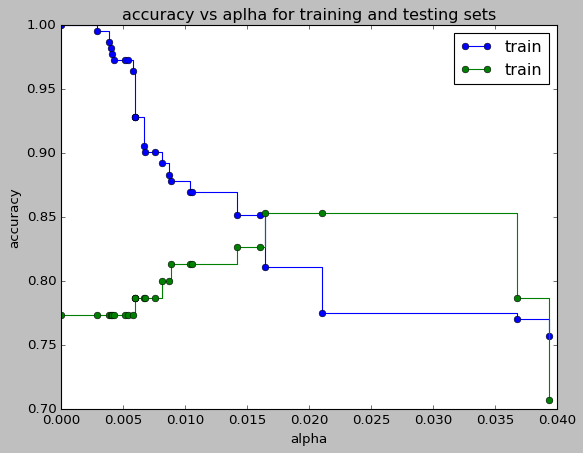

In [36]:
train_scores = [i.score(X_train, y_train) for i in clf_dts]
test_scores = [i.score(X_test, y_test) for i in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs aplha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='train', drawstyle='steps-post')
ax.legend()
plt.show()


**In the graph above we see that the accuracy for the testing dataset hits its max value when alpha is about 0.016.**


## Cross Validation with CCP

best score:  0.7477777777777778
best ccp_aplha:  0.014224751066856332


Text(0.5, 1.0, 'acc vs alpha for cross validation')

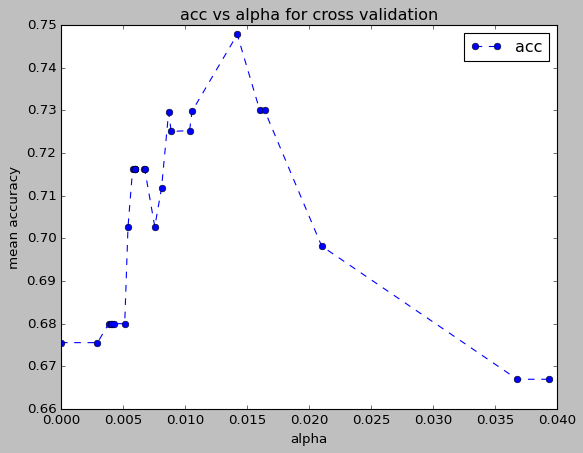

In [37]:
scores = []
scores_alpha = []
#kfold = KFold(n_splits=5, shuffle=True, random_state=23)
for i in ccp_alphas:
    dtc = DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    score = cross_val_score(dtc, X_train, y_train, cv=5)
    scores.append(score.mean())
    scores_alpha.append([i, score.mean()])

i_max = np.argmax(scores)
print("best score: ", scores[i_max])
print("best ccp_aplha: ", ccp_alphas[i_max])

# Plot
scores_result = pd.DataFrame(scores_alpha, columns=['alpha', 'acc'])
scores_result.plot(x='alpha', y='acc', marker='o', linestyle='--')
plt.xlabel("alpha")
plt.ylabel("mean accuracy")
plt.title('acc vs alpha for cross validation')

## Building, Evaluating, Drawing Pruned Classification Tree

Accuracy for pruned Decision Tree : 82.67 % 


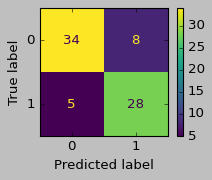

In [289]:
dtc_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[i_max])
dtc_pruned = dtc_pruned.fit(X_train, y_train)
y_pred = dtc_pruned.predict(X_test)
fig, ax = plt.subplots(figsize=(3,2))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
print(f"Accuracy for pruned Decision Tree : {format(accuracy_score(y_test, y_pred)*100, '.2f')} % ")


In the confusion matrix, we see that of the $34+8 = 42$ people that does not have **Heart Disease** 34(81%) were correctly classified. And of the $5+28 = 33$ people that have **Heart Disease**, 28(84.85%) were correctly classified.

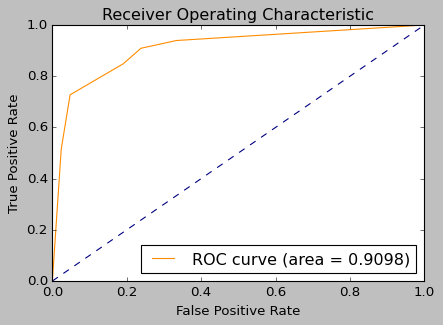

In [296]:
y_scores = dtc_pruned.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
            
# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % np.mean(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

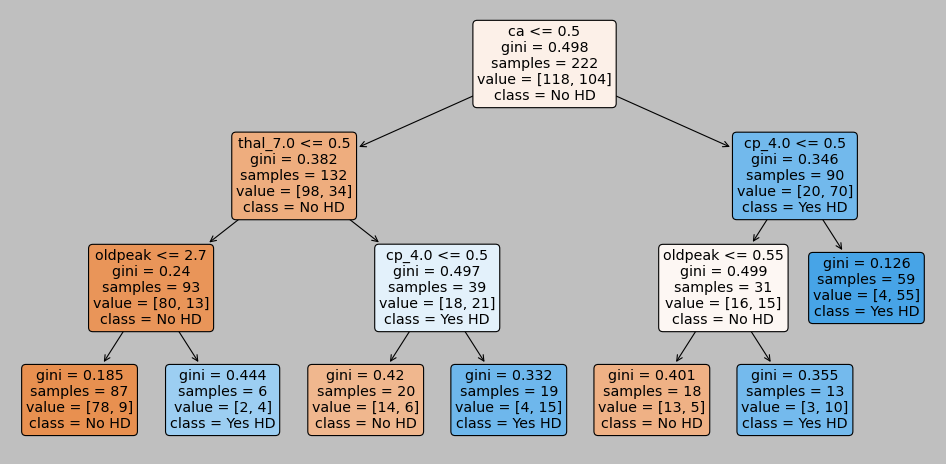

In [198]:
plt.figure(figsize=(15,7))
plot_tree(dtc_pruned.fit(X_train, y_train),
                 filled=True,
                 rounded=True,
                 class_names=['No HD','Yes HD'],
                 feature_names=X_encoded.columns)
plt.show()

## Hyper Parameter tuning using StratifiedKFold

In [199]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
clf = DecisionTreeClassifier(random_state=23)
print(clf.get_params())
params ={'max_depth':[None,3,4,5,6,7], 'min_samples_split':[2,5,10,20],'min_samples_leaf':[1,5,10,20]}
gcv_clf= GridSearchCV(clf, param_grid=params, verbose=3, cv=kfold, scoring='neg_log_loss')
gcv_clf.fit(X_encoded,y)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-9.011 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-8.410 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-9.164 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-10.385 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-11.607 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=-7.835 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_

[CV 3/5] END max_depth=None, min_samples_leaf=20, min_samples_split=20;, score=-0.453 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=20, min_samples_split=20;, score=-1.638 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=20, min_samples_split=20;, score=-1.584 total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=-0.374 total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=-0.496 total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=-0.428 total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=-1.635 total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=-0.553 total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5;, score=-0.374 total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5;, score=-0.496 tota

[CV 3/5] END max_depth=4, min_samples_leaf=1, min_samples_split=10;, score=-0.472 total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_leaf=1, min_samples_split=10;, score=-3.462 total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_leaf=1, min_samples_split=10;, score=-1.698 total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_leaf=1, min_samples_split=20;, score=-0.962 total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_leaf=1, min_samples_split=20;, score=-1.089 total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_leaf=1, min_samples_split=20;, score=-0.430 total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_leaf=1, min_samples_split=20;, score=-2.881 total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_leaf=1, min_samples_split=20;, score=-1.139 total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_leaf=5, min_samples_split=2;, score=-0.918 total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_leaf=5, min_samples_split=2;, score=-1.078 total time=

[CV 5/5] END max_depth=5, min_samples_leaf=5, min_samples_split=2;, score=-4.571 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5;, score=-1.454 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5;, score=-3.246 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5;, score=-1.574 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5;, score=-4.518 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5;, score=-4.571 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=5, min_samples_split=10;, score=-1.454 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=5, min_samples_split=10;, score=-3.246 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=5, min_samples_split=10;, score=-1.574 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=5, min_samples_split=10;, score=-4.518 total time=   0

[CV 1/5] END max_depth=6, min_samples_leaf=5, min_samples_split=10;, score=-1.441 total time=   0.0s
[CV 2/5] END max_depth=6, min_samples_leaf=5, min_samples_split=10;, score=-4.333 total time=   0.0s
[CV 3/5] END max_depth=6, min_samples_leaf=5, min_samples_split=10;, score=-2.141 total time=   0.0s
[CV 4/5] END max_depth=6, min_samples_leaf=5, min_samples_split=10;, score=-3.921 total time=   0.0s
[CV 5/5] END max_depth=6, min_samples_leaf=5, min_samples_split=10;, score=-4.564 total time=   0.0s
[CV 1/5] END max_depth=6, min_samples_leaf=5, min_samples_split=20;, score=-0.918 total time=   0.0s
[CV 2/5] END max_depth=6, min_samples_leaf=5, min_samples_split=20;, score=-1.081 total time=   0.0s
[CV 3/5] END max_depth=6, min_samples_leaf=5, min_samples_split=20;, score=-0.399 total time=   0.0s
[CV 4/5] END max_depth=6, min_samples_leaf=5, min_samples_split=20;, score=-2.275 total time=   0.0s
[CV 5/5] END max_depth=6, min_samples_leaf=5, min_samples_split=20;, score=-2.208 total tim

[CV 4/5] END max_depth=7, min_samples_leaf=10, min_samples_split=2;, score=-1.676 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=10, min_samples_split=2;, score=-2.209 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=10, min_samples_split=5;, score=-0.861 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=10, min_samples_split=5;, score=-1.009 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=10, min_samples_split=5;, score=-1.530 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=10, min_samples_split=5;, score=-1.676 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=10, min_samples_split=5;, score=-2.209 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=10, min_samples_split=10;, score=-0.861 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=10, min_samples_split=10;, score=-1.009 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=10, min_samples_split=10;, score=-1.530 total 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_log_loss', verbose=3)

In [203]:
print(gcv_clf.best_params_)
print(gcv_clf.best_score_)

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
-0.697107524330081


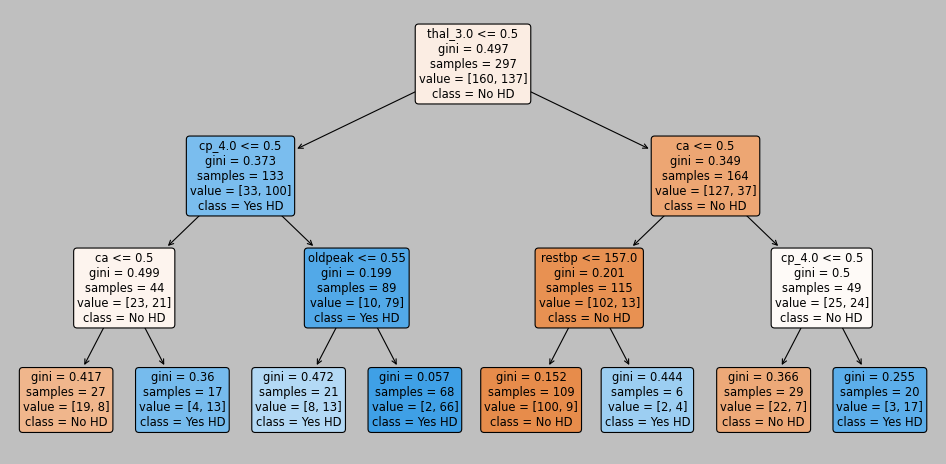

In [205]:
best_clf = gcv_clf.best_estimator_
plt.figure(figsize=(15,7))
plot_tree(best_clf.fit(X_encoded,y),
                 filled=True,
                 rounded=True,
                 class_names=['No HD','Yes HD'],
                 feature_names=X_encoded.columns)
plt.show()

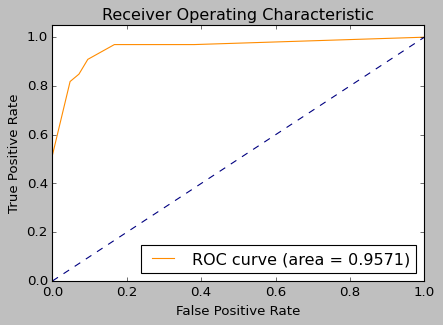

In [297]:
y_scores = best_clf.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
            
# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % np.mean(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.91


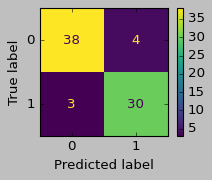

In [269]:
y_pred = best_clf.predict(X_test)
fig, ax = plt.subplots(figsize=(3,2))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
print("Accuracy:",format(accuracy_score(y_test, y_pred),'.2f'))
results['Accuracy'].append(format(accuracy_score(y_test, y_pred),'.2f'))
results['Model'].append('hyper tuned dtc')
results['AUC'].append(np.mean(roc_auc))

## Feature importance plot for decision tree classifier

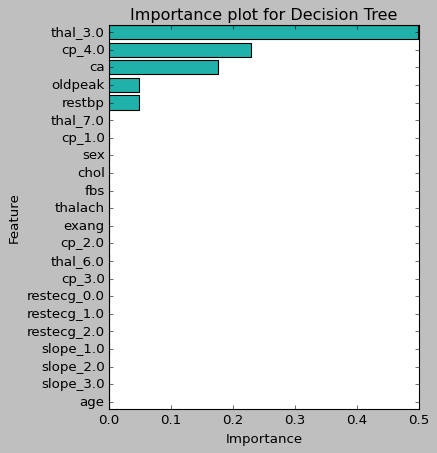

In [208]:
imp = best_clf.feature_importances_
cols = list(X_encoded.columns)
imp_df = pd.DataFrame({'feature':cols, 'importance':imp})
imp_df.sort_values(by='importance', inplace=True)

plt.figure(figsize=(5,6))
plt.barh(imp_df['feature'], imp_df['importance'], color='lightseagreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title("Importance plot for Decision Tree")
plt.show()

## Random Forest Classifier

In [157]:
rf = RandomForestClassifier(random_state=23, ccp_alpha=ccp_alphas[i_max])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
rf_param_grid = {
                 'max_depth' : [4, 6, 8,10],
                 'n_estimators':[50, 100, 150, 250],
                 'max_features': ['sqrt', 'log2'],
                 'min_samples_split': [2, 3, 10,20],
                 'min_samples_leaf': [1, 3, 10,18],
                 'bootstrap': [True, False],
                 'n_jobs':[-1]
                 
                 }


gcv_rf = RandomizedSearchCV(rf, param_distributions=rf_param_grid, verbose=3, cv=kfold, scoring='neg_log_loss', n_iter=100)
gcv_rf.fit(X_encoded,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.364 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.420 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.415 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.476 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.427 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=2

[CV 5/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=18, min_samples_split=10, n_estimators=250, n_jobs=-1;, score=-0.448 total time=   1.1s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.393 total time=   0.6s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.419 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.437 total time=   0.7s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.491 total time=   0.6s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.438 total time=   0.7

[CV 5/5] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=100, n_jobs=-1;, score=-0.423 total time=   0.7s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=18, min_samples_split=10, n_estimators=150, n_jobs=-1;, score=-0.419 total time=   0.8s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=18, min_samples_split=10, n_estimators=150, n_jobs=-1;, score=-0.446 total time=   0.8s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=18, min_samples_split=10, n_estimators=150, n_jobs=-1;, score=-0.464 total time=   0.8s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=18, min_samples_split=10, n_estimators=150, n_jobs=-1;, score=-0.493 total time=   0.8s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=18, min_samples_split=10, n_estimators=150, n_jobs=-1;, score=-0.460 total time=   0.8s

[CV 5/5] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=150, n_jobs=-1;, score=-0.441 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.382 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.408 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.431 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.499 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=-0.428 total time=   0.3s
[CV 1

[CV 5/5] END bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250, n_jobs=-1;, score=-0.425 total time=   1.2s
[CV 1/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=18, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.403 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=18, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.429 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=18, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.446 total time=   0.5s
[CV 4/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=18, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.494 total time=   0.5s
[CV 5/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=18, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.442 total time=   0.5s
[CV 1

[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.438 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.389 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.430 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.436 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.488 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.434 total time=   0.4s
[CV 1/5] 

[CV 5/5] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=18, min_samples_split=3, n_estimators=150, n_jobs=-1;, score=-0.447 total time=   0.6s
[CV 1/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, n_jobs=-1;, score=-0.386 total time=   0.7s
[CV 2/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, n_jobs=-1;, score=-0.416 total time=   0.7s
[CV 3/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, n_jobs=-1;, score=-0.432 total time=   0.7s
[CV 4/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, n_jobs=-1;, score=-0.488 total time=   0.7s
[CV 5/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, n_jobs=-1;, score=-0.434 total time=   0.7s
[CV 

[CV 5/5] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=150, n_jobs=-1;, score=-0.435 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, n_jobs=-1;, score=-0.390 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, n_jobs=-1;, score=-0.410 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, n_jobs=-1;, score=-0.440 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, n_jobs=-1;, score=-0.501 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, n_jobs=-1;, score=-0.436 total time=   0.3s
[CV 

[CV 5/5] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=250, n_jobs=-1;, score=-0.427 total time=   1.4s
[CV 1/5] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.376 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.418 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.426 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.493 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=20, n_estimators=50, n_jobs=-1;, score=-0.431 total time=   0.2s
[CV 1/5] END bo

[CV 5/5] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=18, min_samples_split=20, n_estimators=100, n_jobs=-1;, score=-0.451 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=3, n_estimators=250, n_jobs=-1;, score=-0.405 total time=   1.1s
[CV 2/5] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=3, n_estimators=250, n_jobs=-1;, score=-0.430 total time=   0.9s
[CV 3/5] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=3, n_estimators=250, n_jobs=-1;, score=-0.450 total time=   1.1s
[CV 4/5] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=3, n_estimators=250, n_jobs=-1;, score=-0.495 total time=   0.8s
[CV 5/5] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=3, n_estimators=250, n_jobs=-1;, score=-0.449 total time=   1.1s
[CV 

[CV 5/5] END bootstrap=False, max_depth=4, max_features=log2, min_samples_leaf=18, min_samples_split=2, n_estimators=150, n_jobs=-1;, score=-0.449 total time=   0.6s
{'n_jobs': -1, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
-0.4180749789066692


In [209]:
print(gcv_rf.best_params_)
print(gcv_rf.best_score_)
best_rf = gcv_rf.best_estimator_

{'n_jobs': -1, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
-0.4180749789066692


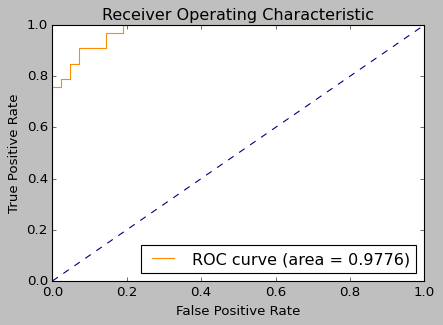

In [215]:
y_scores = best_rf.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
            
# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % np.mean(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy: 0.91


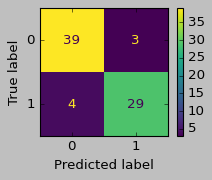

In [216]:
y_pred = best_rf.predict(X_test)
fig, ax = plt.subplots(figsize=(3,2))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
print("accuracy:", format(accuracy_score(y_test, y_pred), '.2f'))

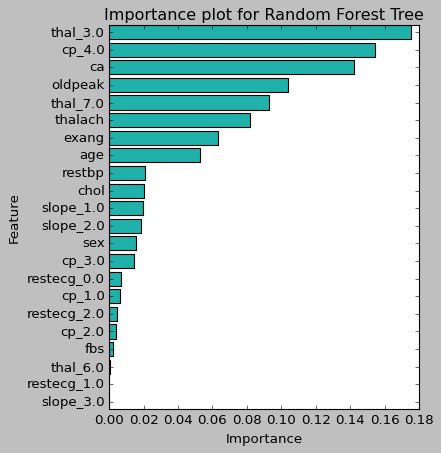

In [217]:
imp = best_rf.feature_importances_
cols = list(X_encoded.columns)
imp_df = pd.DataFrame({'feature':cols, 'importance':imp})
imp_df.sort_values(by='importance', inplace=True)

plt.figure(figsize=(5,6))
plt.barh(imp_df['feature'], imp_df['importance'], color='lightseagreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title("Importance plot for Random Forest Tree")
plt.show()

Xgboost

In [116]:
xg = XGBClassifier(random_state=23)
params = {
    'n_estimators': range(1,20),
    'max_depth': range(1, 10),
    'learning_rate': [.1,.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1],
    'booster':["gbtree"],
     'min_child_weight': [0.001,0.003,0.01],
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
gcv_xg = RandomizedSearchCV(xg, param_distributions=params, verbose=3, cv=kfold, scoring='neg_log_loss', n_iter=100)
gcv_xg.fit(X_encoded,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=8, min_child_weight=0.003, n_estimators=10;, score=-0.368 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=8, min_child_weight=0.003, n_estimators=10;, score=-0.502 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=8, min_child_weight=0.003, n_estimators=10;, score=-0.369 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=8, min_child_weight=0.003, n_estimators=10;, score=-0.497 total time=   0.1s
[CV 5/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=8, min_child_weight=0.003, n_estimators=10;, score=-0.473 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.4, max_depth=7, min_child_weight=0.001, n_estimators=7;, score=-0.356 total time

[CV 5/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.55, max_depth=7, min_child_weight=0.003, n_estimators=9;, score=-0.475 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=8;, score=-0.352 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=8;, score=-0.480 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=8;, score=-0.344 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=8;, score=-0.526 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=8;, score=-0.443 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, learning_rat

[CV 2/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.1, max_depth=9, min_child_weight=0.001, n_estimators=11;, score=-0.473 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.1, max_depth=9, min_child_weight=0.001, n_estimators=11;, score=-0.444 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.1, max_depth=9, min_child_weight=0.001, n_estimators=11;, score=-0.521 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.1, max_depth=9, min_child_weight=0.001, n_estimators=11;, score=-0.471 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.55, max_depth=5, min_child_weight=0.003, n_estimators=15;, score=-0.391 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.55, max_depth=5, min_child_weight=0.003, n_estimators=15;, score=-0.526 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.6, learning_rate

[CV 3/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=0.01, n_estimators=4;, score=-0.582 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=0.01, n_estimators=4;, score=-0.603 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=0.01, n_estimators=4;, score=-0.589 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.6, max_depth=4, min_child_weight=0.003, n_estimators=6;, score=-0.327 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.6, max_depth=4, min_child_weight=0.003, n_estimators=6;, score=-0.461 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.6, max_depth=4, min_child_weight=0.003, n_estimators=6;, score=-0.319 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.6, max_d

[CV 2/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.432 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.387 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.491 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.418 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.55, max_depth=4, min_child_weight=0.01, n_estimators=19;, score=-0.420 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.55, max_depth=4, min_child_weight=0.01, n_estimators=19;, score=-0.483 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, learning_ra

[CV 5/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.55, max_depth=2, min_child_weight=0.01, n_estimators=11;, score=-0.388 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.339 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.465 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.390 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.511 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.5, max_depth=8, min_child_weight=0.001, n_estimators=6;, score=-0.434 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=1, learning_rate=0.

[CV 5/5] END booster=gbtree, colsample_bytree=0.7, learning_rate=0.55, max_depth=7, min_child_weight=0.001, n_estimators=18;, score=-0.510 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=9, min_child_weight=0.003, n_estimators=9;, score=-0.360 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=9, min_child_weight=0.003, n_estimators=9;, score=-0.497 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=9, min_child_weight=0.003, n_estimators=9;, score=-0.389 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=9, min_child_weight=0.003, n_estimators=9;, score=-0.485 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.45, max_depth=9, min_child_weight=0.003, n_estimators=9;, score=-0.450 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.6, learni

[CV 5/5] END booster=gbtree, colsample_bytree=0.6, learning_rate=0.4, max_depth=1, min_child_weight=0.01, n_estimators=11;, score=-0.400 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.6, max_depth=5, min_child_weight=0.001, n_estimators=5;, score=-0.371 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.6, max_depth=5, min_child_weight=0.001, n_estimators=5;, score=-0.464 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.6, max_depth=5, min_child_weight=0.001, n_estimators=5;, score=-0.340 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.6, max_depth=5, min_child_weight=0.001, n_estimators=5;, score=-0.520 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.9, learning_rate=0.6, max_depth=5, min_child_weight=0.001, n_estimators=5;, score=-0.431 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, learning_rate

[CV 3/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.45, max_depth=2, min_child_weight=0.003, n_estimators=16;, score=-0.344 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.45, max_depth=2, min_child_weight=0.003, n_estimators=16;, score=-0.537 total time=   0.0s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.45, max_depth=2, min_child_weight=0.003, n_estimators=16;, score=-0.399 total time=   0.0s
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.6, max_depth=5, min_child_weight=0.01, n_estimators=17;, score=-0.411 total time=   0.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.6, max_depth=5, min_child_weight=0.01, n_estimators=17;, score=-0.456 total time=   0.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.6, max_depth=5, min_child_weight=0.01, n_estimators=17;, score=-0.373 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, learnin

In [218]:
print(gcv_xg.best_params_, "\n")
print("Best Score:",gcv_xg.best_score_)
best_xg = gcv_xg.best_estimator_

{'n_estimators': 16, 'min_child_weight': 0.001, 'max_depth': 1, 'learning_rate': 0.6, 'colsample_bytree': 0.8, 'booster': 'gbtree'} 

Best Score: -0.38755616175211094


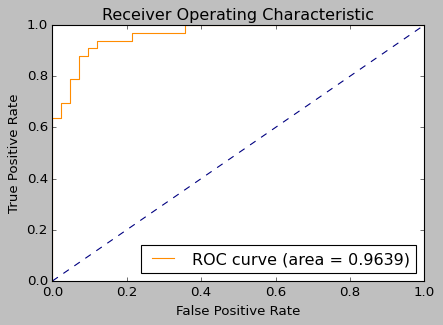

In [219]:
y_scores = best_xg.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
            
# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % np.mean(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Accuracy for Preliminary Decision Tree : 90.67 % 


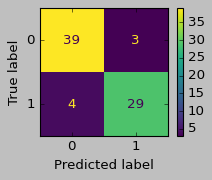

In [300]:
y_pred = best_xg.predict(X_test)
fig, ax = plt.subplots(figsize=(3,2))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
print(f"Accuracy for Preliminary Decision Tree : {format(accuracy_score(y_test, y_pred)*100, '.2f')} % ")

## Logistics Regression

In [227]:
lg = LogisticRegression(random_state=23)
params={
    "C":np.logspace(-3,3,7), 
    "penalty":["l1","l2"]
}# l1 lasso l2 ridge

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
gcv_lg = GridSearchCV(lg, verbose=3, param_grid=params, cv=kfold, scoring='neg_log_loss')
gcv_lg.fit(X_encoded,y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ..............C=0.001, penalty=l2;, score=-0.527 total time=   0.1s
[CV 2/5] END ..............C=0.001, penalty=l2;, score=-0.626 total time=   0.0s
[CV 3/5] END ..............C=0.001, penalty=l2;, score=-0.571 total time=   0.0s
[CV 4/5] END ..............C=0.001, penalty=l2;, score=-0.599 total time=   0.0s
[CV 5/5] END ..............C=0.001, penalty=l2;, score=-0.528 total time=   0.0s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=LogisticRegression(random_state=23),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='neg_log_loss', verbose=3)

In [228]:
print(gcv_lg.best_params_, "\n")
print("Best Score:",gcv_lg.best_score_)
best_lg = gcv_lg.best_estimator_

{'C': 1.0, 'penalty': 'l2'} 

Best Score: -0.36259134617086236


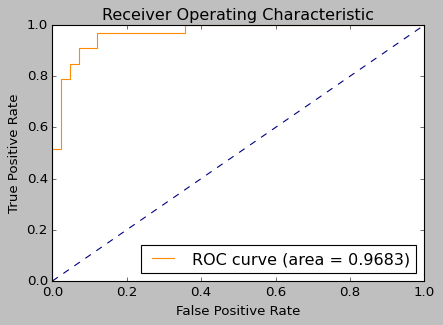

In [229]:
y_scores = best_lg.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
            
# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % np.mean(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.89


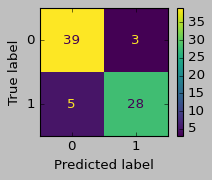

In [230]:
y_pred = best_lg.predict(X_test)
fig, ax = plt.subplots(figsize=(3,2))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
print("Accuracy:",format(accuracy_score(y_test, y_pred),'.2f'))

In [318]:
Results ={
        'base decision tree':{'accuracy':0.76,'auc':0.7024},
        'base decision tree ccp':{'accuracy':0.82,'auc':0.9098},
        'decision tree ccp & hypertuned':{'accuracy':0.91,'auc':0.9571},
        'random forest':{'accuracy':0.91,'auc':0.9776},
        'xgboost':{'accuracy':0.9067,'auc':0.9639},
        'logistics regression':{'accuracy':0.89,'auc':0.9683}}
df = pd.DataFrame(Results).T
sorted_df = df.sort_values(by='auc', ascending=False)
sorted_df.style.background_gradient()